<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
#@title Carga de Librerias

from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


In [234]:
#@title Carga de archivos
from google.colab import files
synth_names = ['am','fm','waveshapping', 'res', 'grain']
AUDIO_LOAD = []
sr16k = 16000
secs = 1

uploaded = files.upload()

for name in synth_names:
  for idx, track in enumerate(uploaded.keys()):
    if track.startswith(name) and track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features
      fft = np.abs(librosa.stft(data))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      AUDIO_LOAD.append({'synth': name , 'data': data, 'fft': fft, 'f0': f0})

##dataframe ordenado que contiene el tipo de sintesis y datos
DATA = pd.DataFrame(AUDIO_LOAD)
DATA.sort_values(['synth'], ignore_index= True)

print('User uploaded file "{name}" with length {length} bytes'.format(
      name= track, length=len(uploaded[track])))


Saving am_7.wav to am_7 (1).wav
Saving am_8.wav to am_8 (1).wav
Saving am_9.wav to am_9 (1).wav
Saving fm_0.wav to fm_0 (1).wav
Saving fm_1.wav to fm_1 (1).wav
Saving fm_2.wav to fm_2 (1).wav
User uploaded file "fm_2.wav" with length 144044 bytes


In [235]:
DATA

,synth,data,fft,f0
0,am,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.049092367, 0.09554064, 0.08853424, 0.05410...",53.343305
1,am,"[-0.008804848, -0.014468155, -0.012261509, -0....","[[0.85226285, 0.6608369, 0.3457113, 0.20664123...",129.895208
2,am,"[-0.15124077, -0.23614876, -0.1822076, -0.1816...","[[19.318117, 9.635053, 0.04001665, 0.017144881...",121.835825
3,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.9569726, 1.0313575, 0.052846853, 3.9973223...",2046.747629
4,fm,"[0.004135562, 0.014386324, 0.013820173, 0.0033...","[[0.031439066, 0.015683154, 7.08784e-05, 6.245...",2285.714286
5,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.22422291, 0.11858162, 0.0063518207, 0.0002...",193.033735


In [206]:
#@title Filtrado

count = np.array(DATA['synth'].value_counts())
am_data = widgets.IntSlider(value = count[0], max= count[0], description='am data')
fm_data = widgets.IntSlider(value = count[0], max= count[1], description='fm data')
c = widgets.IntSlider(value = count[0], max= count[0], description='b')
ui = widgets.VBox([am_data, fm_data, c])

def f(a, b, c):
  df = DATA.iloc[0: a]
  df_2 = DATA.iloc[count[0]: b + count[0]]
  #df_3 = DATA.iloc[b: c]
  DATA_filt = pd.concat([df, df_2])
  #print(type(DATA_filt))
  print(DATA_filt['synth'])
  return DATA_filt

out = widgets.interactive_output(f, {'a': am_data, 'b': fm_data, 'c': c})

display(ui, out)

Output()

In [195]:
#@title DATASET

df = DATA.iloc[0: a.value]
df_2 = DATA.iloc[count[0]: b.value + count[0]]
#df_3 = DATA.iloc[b: c]
DATA_filt = pd.concat([df, df_2])
DATA_filt

,synth,data,fft,f0
0,am,"[-0.035109878, -0.056301363, -0.045687754, -0....","[[2.1280713, 1.4650475, 2.0745838, 4.082849, 2...",56.071033
1,am,"[0.016557282, 0.030276692, 0.030050265, 0.0350...","[[20.652113, 11.848607, 21.264864, 1.5300363, ...",76.253556
6,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.9569726, 1.0313575, 0.052846853, 3.9973223...",2046.747629
7,fm,"[0.004135562, 0.014386324, 0.013820173, 0.0033...","[[0.031439066, 0.015683154, 7.08784e-05, 6.245...",2285.714286
8,fm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.22422291, 0.11858162, 0.0063518207, 0.0002...",193.033735


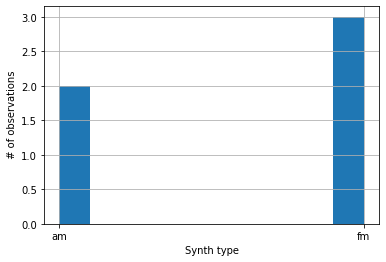

In [237]:
#@title Vizualización de datos
audio_viz= 'histogram' #@param ['PCA','F0', 'histogram']
fig, ax = plt.subplots()
if audio_viz == 'histogram':
  ax = DATA_filt['synth'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  plt.show()

In [238]:
###normalizar y cambio de dimensionalidad
data = np.array(DATA_filt['data'])
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]

Xw = (waveforms- mu_wave)#/max_wave
## para evitar la division entre ceros
Xw = np.divide(Xw, max_wave, out=np.zeros(Xw.shape, dtype=float), where=max_wave!=0)
print(Xw.shape)

Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

NameError: ignored

In [239]:
data = np.vstack(DATA_filt['data'])
data.shape
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]

Xw = (data- mu_wave)#/max_wave
## para evitar la division entre ceros
Xw = np.divide(Xw, max_wave, out=np.zeros(Xw.shape, dtype=float), where=max_wave!=0)
print(Xw.shape)

Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(5, 16000)
(5, 16000, 1, 1)


In [240]:
#@title Entrenamiento del modelo
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.000001)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))


latent_dim = 128
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
#vae_encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
#vae_decoder.summary()


# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= 5, epochs= 30)


Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 8/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 9/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 10/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 11/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 12/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 13/30
1/1 [==============================] - 2s 2s/step - loss: 0.1176
Epoch 14

In [249]:
y_hat = vae.predict(Xw)

TypeError: ignored

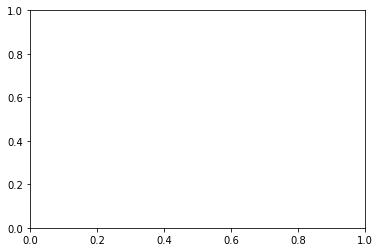

In [250]:
#@title Visualización del espacio latente


fig, ax = plt.subplots()

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)

X_PCA = pca.fit_transform(latent[0])


In [244]:
X_PCA.shape

(1025, 2)

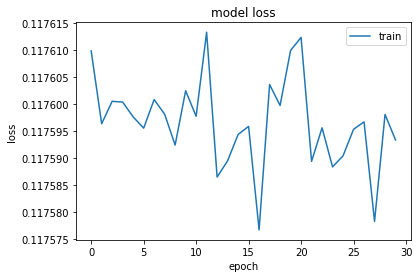

In [241]:
plt.plot(tr_logs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [248]:
latent[0]

<KerasTensor: shape=(84, 1, 512) dtype=float32 (created by layer 'tf.__operators__.getitem_3')>

[0, 1, 2]


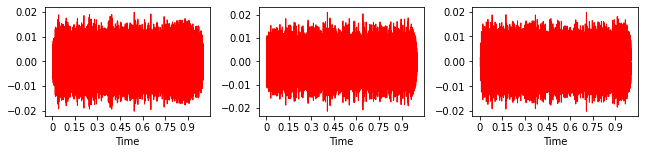

In [242]:
y_hat = vae.predict(Xw)
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(3)]
print(sonidos)
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1)
    librosa.display.waveshow(y_hat[x].flatten(),16000, color='r')
plt.tight_layout()
plt.show()

In [ ]:
#@title Generación de Audios
Audio de referencia 1 = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']
Audio de referencia 2 = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

tecnicas = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

NameError: ignored

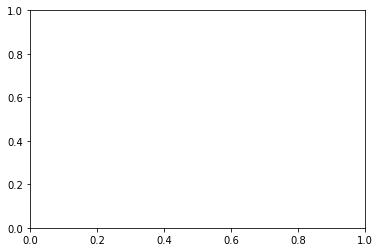

In [205]:
fig, ax = plt.subplots()
pca = PCA(n_components= 2)
X_PCA = pca.fit_transform(x)
ax.scatter(X_PCA[:len(res[0]), 0], X_PCA[:len(res[0]), 1], c = 'r')
ax.scatter(X_PCA[:len(res[1]), 0], X_PCA[:len(res[1]), 1], c = 'b')
print(pca.explained_variance_ratio_)
plt.show()

In [69]:
#@title Vizualización de datos

count = np.array(DATA['synth'].value_counts())
#filter_by = 'dataset' #@param ['dataset', 'f0']


a = widgets.IntRangeSlider(value= [30,20000], min = 20, max = 20000, description='f0')
d = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled= False,
)

def f(p,q):
  return (p,q)

interact(f, p=5, q=fixed(20));

  print('hola')
b = widgets.IntSlider(value = count[0], max= count[0], description='b')
c = widgets.IntSlider(value = count[1], max= count[1], description='b')
widgets.HBox([widgets.VBox([a, b,c, d])])

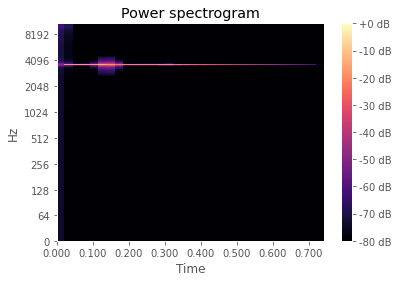

In [ ]:
DATA['fft'][0]

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(DATA['fft'][3],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")